In [20]:
!wget http://helon.usuarios.rdc.puc-rio.br/data/data3SS2009.mat

--2022-03-27 12:47:38--  http://helon.usuarios.rdc.puc-rio.br/data/data3SS2009.mat
Resolving helon.usuarios.rdc.puc-rio.br (helon.usuarios.rdc.puc-rio.br)... 139.82.34.10
Connecting to helon.usuarios.rdc.puc-rio.br (helon.usuarios.rdc.puc-rio.br)|139.82.34.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 267634147 (255M)
Saving to: ‘data3SS2009.mat.1’

data3SS2009.mat.1     7%[>                   ]  19,02M  4,96MB/s    eta 51s    ^C


In [42]:
import pandas as pd
import sklearn
import scipy.io as sio
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
from sklearn import linear_model, decomposition, preprocessing,metrics, model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

In [16]:
fname = join(os.getcwd(),'data','data3SS2009.mat')
mat_contents = sio.loadmat(fname)
dataset = mat_contents['dataset']
N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases
y = mat_contents['labels'].reshape(Nc)
y

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5

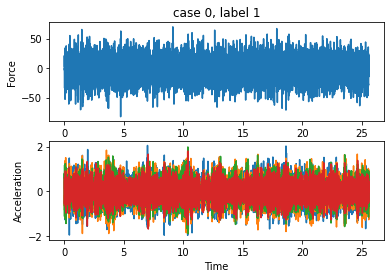

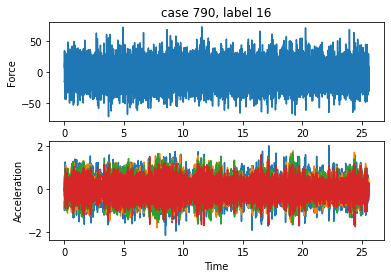

In [5]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.figure(case)
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time,Ch2[:,case],time,Ch3[:,case],time,Ch4[:,case],time,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()

# 4.a - Extração características utilizando o modelo AR

- O modelo AR (autoregressivo) é um modelo de treinamento para fazer previsões baseado em n dados passados, chamados lags. 

- Para utilizar um modelo AR é importante que os dados sejam auto-correlacionados, por isto é um modelo muito aplicado para previsões de séries temporais. Pelo mesmo motivo é necessária uma análise exploratória para definir o melhor valor para o lag. 
Neste exercício será utilizado lag=30 devido ao enunciado, porém abaixo segue exemplo do cálculo de autocorrelações parciais de um experimento para um canal.
    - a área hachurada em azul, enfatiza onde não há evidência que o valor é diferente de zero. Portanto, todos os valores fora desta área podem ser escolhidos como ordem do modelo para este experimento.
    - desta forma, olhando apenas para o experimento 1, verifica-se que um valor de 29 para o lag seria mais adequado, uma vez que no Ch4 o lag=30 está na área azul.
    
- Outras formas de se determinar o lag: AIC, BIC,...

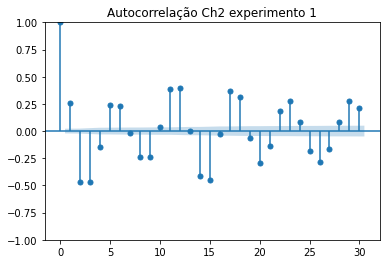

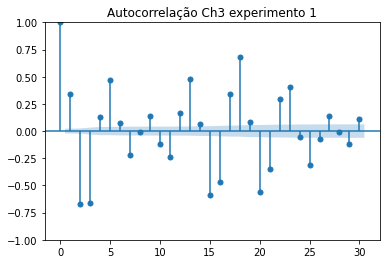

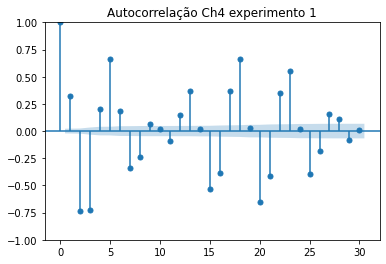

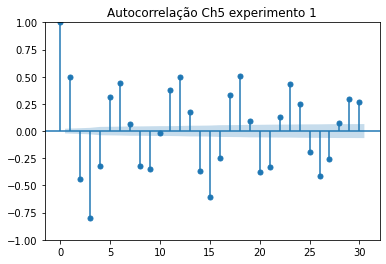

In [6]:
tsaplots.plot_acf(Ch2[:,0], lags=30,title='Autocorrelação Ch2 experimento 1')
tsaplots.plot_acf(Ch3[:,0], lags=30,title='Autocorrelação Ch3 experimento 1')
tsaplots.plot_acf(Ch4[:,0], lags=30,title='Autocorrelação Ch4 experimento 1')
tsaplots.plot_acf(Ch5[:,0], lags=30,title='Autocorrelação Ch5 experimento 1')
plt.show()

In [8]:
X1=[]
for i in range(0,850): # a regressão é realizada para extrair características de cada experimento, por isto são realizadas a extração de características 850 vezes
    pAR2 = AutoReg(Ch2[:,i], lags = 30).fit()
    pAR3 = AutoReg(Ch3[:,i], lags = 30).fit()
    pAR4 = AutoReg(Ch4[:,i], lags = 30).fit()
    pAR5 = AutoReg(Ch5[:,i], lags = 30).fit()
    result=np.concatenate([pAR2.params,pAR3.params,pAR4.params,pAR5.params])
    X1.append(result)

# 4.b - Redução de dimensionalidade utilizando PCA

- Um dos algoritmos de redução de dimensionalidade mais popular, funciona projetando o conjunto de dados no hiper-plano que melhor preserva a variância de forma a perder o minimo de informação. Depois, para cada dimensão do conjunto de dados, o algoritmo do PCA encontra outro hiperplano ortogonal ao primeiro de forma a explicar a variância remanescente.
- Para escolher o percentual da variância explicada para a redução de componentes foi plotado o gráfico do número de componentes necessários para explicar a variância e optou-se por um número a partir do qual a variância não apresentava crescimento rápido.

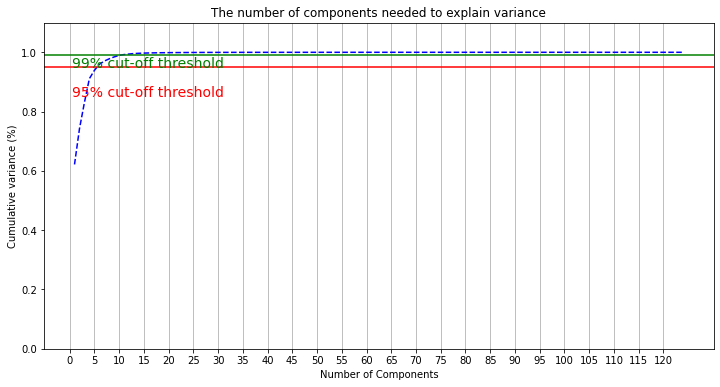

In [9]:
pca = PCA().fit(X1)

plt.rcParams["figure.figsize"] = (12,6)
fig, ax = plt.subplots()
xi = np.arange(1, 125, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 125, step=5)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=14)
plt.axhline(y=0.99, color='g', linestyle='-')
plt.text(0.5, 0.95, '99% cut-off threshold', color = 'green', fontsize=14)

ax.grid(axis='x')
plt.show()

In [10]:
pca = decomposition.PCA(n_components=0.97) #variancia explicada 97%
X2 = pca.fit_transform(X1)
Nc,PCAcomp=X2.shape 
#Nc = numero de experimentos (o mesmo do início do código, este número não se alterou)
#PCAcomp = numero de componentes resultado do PCA

# 4.b - Escalonamento dos fatores

In [11]:
scaler = MinMaxScaler(feature_range=(-1,1))
X1_=scaler.fit_transform(X1)
X2_=scaler.fit_transform(X2)

# 4.c - Comparação entre o modelo reduzido apenas pelo método AR e o modelo reduzido com o método AR e o PCA

- Abaixo foram plotados gráficos multidimensionais para os dois modelos a fim de comparar o impacto da aplicação do PCA.
- Verifica-se que, além de reduzir a quantidade de dimensões em 95%, a aplicação do PCA deixa mais explícita as informações que cada dimensão contém acerca da classificação das falhas.

In [20]:
indDam = y>9
dfARred=pd.concat([pd.DataFrame(X1_),pd.DataFrame({'target':indDam})],axis=1)
dfARPCAred=pd.concat([pd.DataFrame(X2_),pd.DataFrame({'target':indDam})],axis=1)
dfARPCAred

,0,1,2,3,4,5,6,target
0,0.728961,-0.619964,-0.172817,0.170078,0.436143,-0.107413,0.086956,False
1,0.617676,-0.718114,-0.275081,0.322682,0.387425,-0.289742,0.260166,False
2,0.629277,-0.670517,-0.271454,0.314041,0.178929,-0.251572,0.061377,False
3,0.666789,-0.908744,-0.696502,0.229063,0.428189,0.199742,0.121814,False
4,0.635523,-0.730507,-0.467551,0.283835,0.092537,-0.041819,-0.067426,False
...,...,...,...,...,...,...,...,...
845,-0.918601,-0.368052,0.176000,0.260461,-0.198088,0.010965,0.180781,True
846,-0.898883,-0.588371,0.142308,0.001967,-0.366838,0.245082,0.500103,True
847,-0.924074,-0.651231,-0.242938,0.340013,-0.286763,0.396455,0.480315,True
848,-0.896291,-0.615915,-0.005804,0.108046,-0.361431,0.312411,0.399231,True


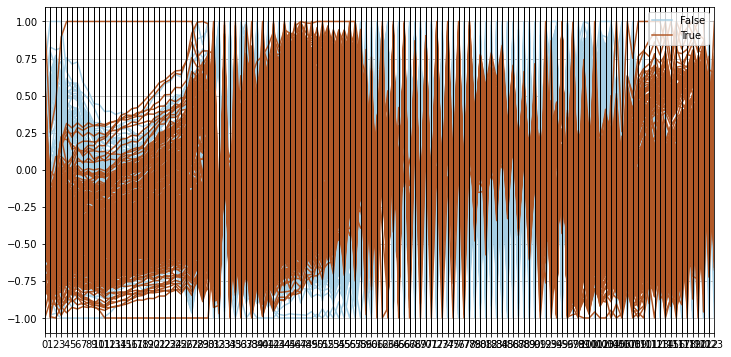

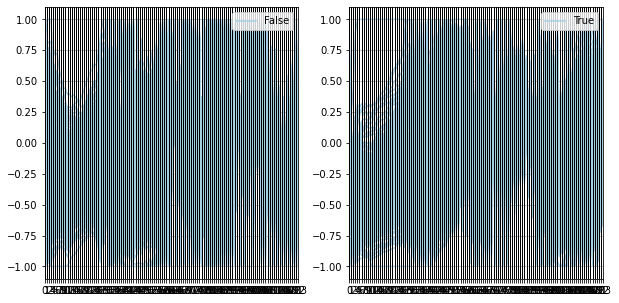

In [21]:
plt.figure()
pd.plotting.parallel_coordinates(dfARred,'target',colormap=plt.get_cmap('Paired'))
plt.show()

plt.figure(figsize=[10,5])
plt.subplot(121)
pd.plotting.parallel_coordinates(dfARred[dfARred['target']==0],'target',colormap=plt.get_cmap('Paired'))
plt.subplot(122)
pd.plotting.parallel_coordinates(dfARred[dfARred['target']==1],'target',colormap=plt.get_cmap('Paired'))
plt.show()

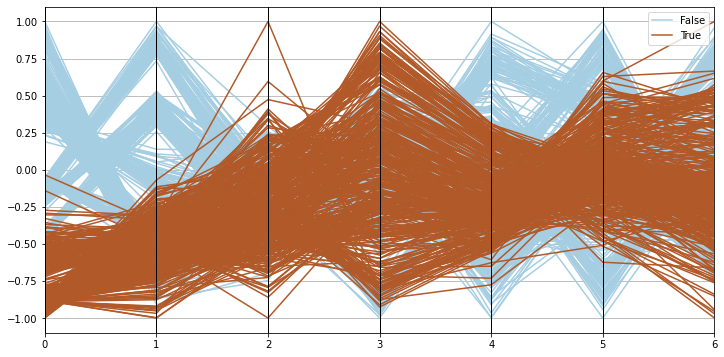

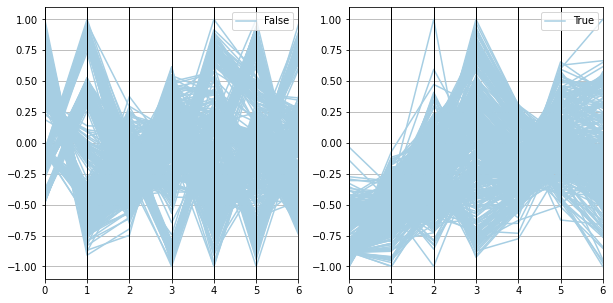

In [22]:
plt.figure()
pd.plotting.parallel_coordinates(dfARPCAred,'target',colormap=plt.get_cmap('Paired'))
plt.show()

plt.figure(figsize=[10,5])
plt.subplot(121)
pd.plotting.parallel_coordinates(dfARPCAred[dfARred['target']==0],'target',colormap=plt.get_cmap('Paired'))
plt.subplot(122)
pd.plotting.parallel_coordinates(dfARPCAred[dfARred['target']==1],'target',colormap=plt.get_cmap('Paired'))
plt.show()

# 5- Construção do Modelo (Softmax Regression)

- Softmax Regression é um método de <b>classificação</b>.
- É uma generalização do modelo logístico para problemas com mais de dois resultados discretos.

In [69]:
df=pd.concat([pd.DataFrame(X2_),pd.DataFrame({'State Condition':y})],axis=1)
#divisao dos dados em teste e treino
df_treino,df_teste=train_test_split(df,test_size=0.3)
input_treino=df_treino.drop(['State Condition'],axis=1)
output_treino=df_treino['State Condition']
input_teste=df_teste.drop(['State Condition'],axis=1)
output_teste=df_teste['State Condition']

#regressao
softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs")
softmax_reg.fit(input_treino, output_treino)
teste_absoluto=softmax_reg.predict(input_teste)
teste_probabilidade=softmax_reg.predict_proba(input_teste)